In [1]:
# import
import os
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.spatial import distance
from sklearn.cluster import KMeans
from tqdm import tqdm

# import plotting libraries
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
plt.rcParams['svg.fonttype'] = 'none'
import seaborn as sns
from nilearn import datasets
from nilearn import plotting

# import network_control functions
from network_control.energies import ComputeControlEnergy, integrate_u
from network_control.energies import optimal_input as get_control_inputs
from network_control.metrics import ave_control
from network_control.utils import matrix_normalization, convert_states_str2float, normalize_state, get_null_p
from network_control.plotting import roi_to_vtx, null_plot, surface_plot
from null_models.geomsurr import geomsurr

In [2]:
# directory where data is stored
datadir = '/Users/lindenmp/Google-Drive-Penn/work/research_projects/control_package/data'
resultsdir = '/Users/lindenmp/Google-Drive-Penn/work/research_projects/control_package/results'
A_file = 'pnc_schaefer200_Am.npy'

In [3]:
# load A matrix
A = np.load(os.path.join(datadir, A_file))
n_nodes = A.shape[0]
print(A.shape)

(200, 200)


In [4]:
# normalize
A[np.eye(A.shape[0]).astype(bool)] = 0
version = 'continuous'
A_norm = matrix_normalization(A, version=version, c=1)

In [5]:
# load node-to-system mapping
system_labels = list(np.loadtxt(os.path.join(datadir, 'pnc_schaefer200_system_labels.txt'), dtype=str))

In [6]:
print(len(system_labels))
print(system_labels[:20])

200
['Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'SomMot', 'SomMot', 'SomMot', 'SomMot', 'SomMot', 'SomMot']


In [7]:
# use list of system names to create states
states, state_labels = convert_states_str2float(system_labels)

In [8]:
print(type(state_labels), len(state_labels))
print(state_labels)

<class 'list'> 7
['Cont', 'Default', 'DorsAttn', 'Limbic', 'SalVentAttn', 'SomMot', 'Vis']


In [9]:
print(type(states), states.shape)
print(states)

<class 'numpy.ndarray'> (200,)
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 2 2 2 2 2 2
 2 2 2 2 2 2 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 2 2 2 2 2 2 2 2 2 2 2 2 4
 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [10]:
# extract initial state
x0 = states == state_labels.index('Vis')

# extract target state
xf = states == state_labels.index('Default')

In [11]:
# normalize state magnitude
x0 = normalize_state(x0)
xf = normalize_state(xf)

In [12]:
# specify a uniform full control: all nodes are control nodes
# and all control nodes are assigned equal control weight
B = np.eye(n_nodes)

In [13]:
# set parameters
T = 1 # time horizon
rho = 1 # mixing parameter for state trajectory constraint
S = np.eye(n_nodes) # nodes in state trajectory to be constrained

# get the state trajectory (x) and the control inputs (u)
x, u, n_err = get_control_inputs(A_norm, T, B, x0, xf, rho, S)

# check for state completion. We expect to see 0 here,
# which indicates no difference between the model at the end of the simulation at xf
print(np.round(np.sum(np.square(x[-1, :] - xf)), 8))

0.0


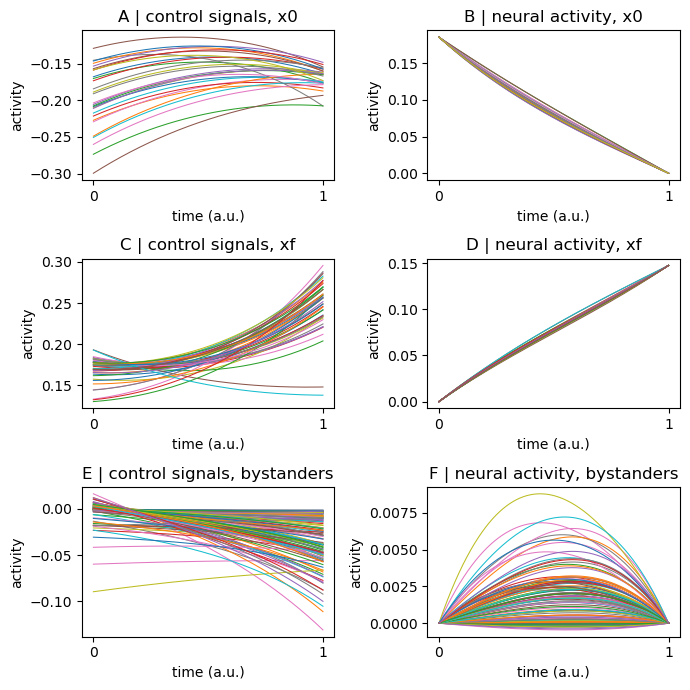

In [14]:
f, ax = plt.subplots(3, 2, figsize=(7, 7))
# plot control signals for initial state
ax[0, 0].plot(u[:, x0 != 0], linewidth=0.75)
ax[0, 0].set_title('A | control signals, x0')
# plot state trajectory for initial state
ax[0, 1].plot(x[:, x0 != 0], linewidth=0.75)
ax[0, 1].set_title('B | neural activity, x0')

# plot control signals for target state
ax[1, 0].plot(u[:, xf != 0], linewidth=0.75)
ax[1, 0].set_title('C | control signals, xf')
# plot state trajectory for target state
ax[1, 1].plot(x[:, xf != 0], linewidth=0.75)
ax[1, 1].set_title('D | neural activity, xf')

# plot control signals for bystanders
ax[2, 0].plot(u[:, np.logical_and(x0 == 0, xf == 0)], linewidth=0.75)
ax[2, 0].set_title('E | control signals, bystanders')
# plot state trajectory for bystanders
ax[2, 1].plot(x[:, np.logical_and(x0 == 0, xf == 0)], linewidth=0.75)
ax[2, 1].set_title('F | neural activity, bystanders')

for cax in ax.reshape(-1):
    cax.set_ylabel("activity")
    cax.set_xlabel("time (a.u.)")
    cax.set_xticks([0, x.shape[0]])
    cax.set_xticklabels([0, T])

f.tight_layout()
f.savefig(os.path.join(resultsdir, 'plot_xu.svg'), dpi=600, bbox_inches='tight', pad_inches=0.01)
plt.show()

In [15]:
# integrate control inputs to get control energy
node_energy = integrate_u(u)
print(node_energy.shape)
print(np.round(node_energy[:5], 2))

# summarize nodal energy
energy = np.sum(node_energy)
print(np.round(energy, 2))

(200,)
[22.36 37.07 24.51 22.5  28.93]
2640.88


In [16]:
# null networks
centroids = pd.read_csv(os.path.join(datadir, 'pnc_schaefer200_centroids.csv'))  # load coordinates of nodes
centroids.set_index('node_names', inplace=True)
print(centroids.head())

D = distance.pdist(centroids, 'euclidean')  # get euclidean distances between nodes
D = distance.squareform(D)  # reshape to square matrix

            vox_x  vox_y  vox_z
node_names                     
LH_Vis_1      121    149     69
LH_Vis_2      123    174     65
LH_Vis_3      143    166     70
LH_Vis_4      107    164     74
LH_Vis_5      124    192     66


In [17]:
# to paste into manuscript
run = False

if run:
    # extract initial state
    x0 = states == state_labels.index('Vis')
    x0 = normalize_state(x0)  # normalize

    # extract target state
    xf = states == state_labels.index('Default')
    xf = normalize_state(xf)  # normalize

    # get true control energy
    x, u, n_err = get_control_inputs(A_norm, T, B, x0, xf, rho, S)  # get u
    E = integrate_u(u)  # integrate u
    E = np.sum(E)  # get energy

    # run permutation
    n_perms = 10000  # number of permutations

    # containers for null distributions
    energy_null_sp = np.zeros(n_perms)
    energy_null_ssp = np.zeros(n_perms)

    for i in tqdm(np.arange(n_perms)):
        _, Wsp, Wssp = geomsurr(W=A, D=D, seed=i)  # rewire adjacency matrix using geomsurr
        # Wsp is A rewired while preserving spatial embedding and the strength distribution
        # Wssp is A rewired while preserving spatial embedding and the strength sequence
        # this python implementation is included with our toolbox, but if you use these nulls
        # in your own work, please cite:
        #       Roberts et al. NeuroImage (2016), doi:10.1016/j.neuroimage.2015.09.009

        Wsp = matrix_normalization(Wsp, version=version)  # normalize rewired adjacency matrix
        x, u, n_err = get_control_inputs(Wsp, T, B, x0, xf, rho, S)  # get u
        e = integrate_u(u)  # integrate null u
        energy_null_sp[i] = np.sum(e)  # store null energy

        Wssp = matrix_normalization(Wssp, version=version)  # normalize rewired adjacency matrix
        x, u, n_err = get_control_inputs(Wssp, T, B, x0, xf, rho, S)  # get u
        e = integrate_u(u)  # integrate null u
        energy_null_ssp[i] = np.sum(e)  # store null energy

    # plot
    f, ax = plt.subplots(1, 2, figsize=(7, 3))
    null_plot(observed=E, null=energy_null_sp,
              xlabel='energy null (space & str. dist.)', ax=ax[0])
    null_plot(observed=E, null=energy_null_ssp,
              xlabel='energy null (space & str. seq.)', ax=ax[1])
    f.tight_layout()
    f.savefig(os.path.join(resultsdir, 'energy_network_null.svg'), dpi=600, bbox_inches='tight', pad_inches=0.01)
    plt.show()

In [18]:
# for figures
run = False
if run:
    n_perms = 10000

    transitions = [['Vis', 'Default'],
                   ['Default', 'Vis']]
    for transition in transitions:
        # extract initial state
        state_i = transition[0]
        x0 = states == state_labels.index(state_i)
        x0 = normalize_state(x0)

        # extract target state
        state_j = transition[1]
        xf = states == state_labels.index(state_j)
        xf = normalize_state(xf)

        print(state_i, state_j)

        energy_null_sp = np.zeros(n_perms)
        energy_null_ssp = np.zeros(n_perms)

        for i in tqdm(np.arange(n_perms)):
            _, Wsp, Wssp = geomsurr(W=A, D=D, seed=i)

            Wsp = matrix_normalization(Wsp, version=version)  # normalize rewired adjacency matrix
            x, u, n_err = get_control_inputs(Wsp, T, B, x0, xf, rho, S)  # get u
            e = integrate_u(u)  # integrate null u
            energy_null_sp[i] = np.sum(e)  # store null energy

            Wssp = matrix_normalization(Wssp, version=version)  # normalize rewired adjacency matrix
            x, u, n_err = get_control_inputs(Wssp, T, B, x0, xf, rho, S)  # get u
            e = integrate_u(u)  # integrate null u
            energy_null_ssp[i] = np.sum(e)  # store null energy

        np.save(os.path.join(resultsdir, 'energy_null_sp_{0}_{1}'.format(state_i, state_j)), energy_null_sp)
        np.save(os.path.join(resultsdir, 'energy_null_ssp_{0}_{1}'.format(state_i, state_j)), energy_null_ssp)
else:
    pass

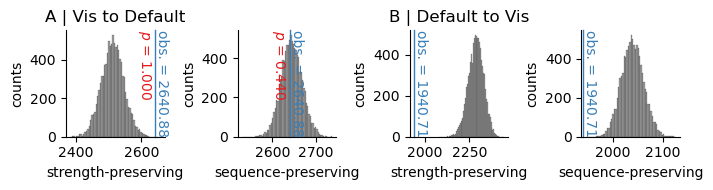

In [19]:
run = True
if run:
    f, ax = plt.subplots(1, 4, figsize=(7, 2))

    # i-->j
    state_i = 'Vis'
    x0 = states == state_labels.index(state_i)
    x0 = normalize_state(x0)
    state_j = 'Default'
    xf = states == state_labels.index(state_j)
    xf = normalize_state(xf)

    x, u, n_err = get_control_inputs(A_norm, T, B, x0, xf, rho, S)
    E = integrate_u(u)
    E = np.sum(E)

    energy_null_sp = np.load(os.path.join(resultsdir, 'energy_null_sp_{0}_{1}.npy'.format(state_i, state_j)))
    energy_null_ssp = np.load(os.path.join(resultsdir, 'energy_null_ssp_{0}_{1}.npy'.format(state_i, state_j)))

    p_val = get_null_p(E, energy_null_sp, version='reverse', abs=False)
    null_plot(observed=E, null=energy_null_sp, p_val=p_val, xlabel='strength-preserving', ax=ax[0])
    ax[0].set_title('A | {0} to {1}'.format(state_i, state_j))

    p_val = get_null_p(E, energy_null_ssp, version='reverse', abs=False)
    null_plot(observed=E, null=energy_null_ssp, p_val=p_val, xlabel='sequence-preserving', ax=ax[1])

    # j-->i
    state_i = 'Default'
    x0 = states == state_labels.index(state_i)
    x0 = normalize_state(x0)
    state_j = 'Vis'
    xf = states == state_labels.index(state_j)
    xf = normalize_state(xf)

    x, u, n_err = get_control_inputs(A_norm, T, B, x0, xf, rho, S)
    E = integrate_u(u)
    E = np.sum(E)

    energy_null_sp = np.load(os.path.join(resultsdir, 'energy_null_sp_{0}_{1}.npy'.format(state_i, state_j)))
    energy_null_ssp = np.load(os.path.join(resultsdir, 'energy_null_ssp_{0}_{1}.npy'.format(state_i, state_j)))

    p_val = get_null_p(E, energy_null_sp, version='reverse', abs=False)
    null_plot(observed=E, null=energy_null_sp, p_val=p_val, xlabel='strength-preserving', ax=ax[2])
    ax[2].set_title('B | {0} to {1}'.format(state_i, state_j))

    p_val = get_null_p(E, energy_null_ssp, version='reverse', abs=False)
    null_plot(observed=E, null=energy_null_ssp, p_val=p_val, xlabel='sequence-preserving', ax=ax[3])

    f.tight_layout()
    f.savefig(os.path.join(resultsdir, 'energy_network_null.svg'), dpi=600, bbox_inches='tight', pad_inches=0.01)
    plt.show()

In [20]:
# strength of states

# extract initial state
x0 = states == state_labels.index('Vis')

# extract target state
xf = states == state_labels.index('Default')

s = np.sum(A, axis=0)
print('Visual state strength: {0}'.format(np.mean(s[x0])))
print('DMN state strength: {0}'.format(np.mean(s[xf])))
bystanders = x0 + xf
bystanders = ~bystanders
print('remaining nodes: {0}'.format(np.mean(s[bystanders])))


Visual state strength: 62707.33152064782
DMN state strength: 55613.37058108447
remaining nodes: 50452.25378589372
